## libs

In [18]:
# python utils
import itertools
import inspect
import random
import pickle

# pre-processing and exploring data
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import statistics
from sklearn.preprocessing import StandardScaler

# viz
import matplotlib.pyplot as plt
font = {'size'   : 15}
plt.rc('font', **font)

# model building
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data
from keras.losses import mean_squared_error

## Import Data

In [2]:
# artificial data with outliers

contamination = 0.1  # percentage of outliers
n_train = 700  # number of training points
n_test = 700  # number of testing points
n_features = 18 # Number of features

X_data, y_data = generate_data(
    n_train=n_train, n_test=n_test,
    n_features= n_features, 
    train_only=True,
    contamination=contamination,random_state=1234)

## Preprocessing Data

In [3]:
# to pandas df
X_data = pd.DataFrame(X_data)
X_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,3.892732,2.805184,2.550995,3.552799,3.535617,2.603377,3.009781,1.602563,3.716597,3.618090,3.594025,1.740538,2.791833,3.001320,3.252642,3.180136,3.823225,2.036110
1,2.873729,2.591260,3.120523,3.344853,3.821352,2.707572,3.420944,1.867794,2.885903,3.659853,2.752102,3.210260,3.652755,3.651733,3.538190,2.923924,3.077710,2.798864
2,3.524455,4.489828,3.047481,2.647043,3.022520,1.707063,3.154401,2.440974,2.914762,3.011396,3.470705,3.134136,3.524040,2.099103,2.126418,2.937117,2.658385,2.909886
3,3.220593,2.977872,3.352517,3.963114,2.392945,2.956167,3.191898,2.870083,3.644170,1.504256,4.265287,2.288016,3.132026,3.439118,2.510588,3.287913,3.438811,3.326202
4,2.422843,4.251105,3.141422,2.281768,3.393792,3.024621,3.289367,0.779542,3.823192,3.095105,3.102520,2.732004,3.478154,3.613712,3.168760,3.867359,3.049750,2.750779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,1.281831,1.062482,-0.439999,0.445105,1.399909,-0.780047,0.327582,-1.303468,2.596278,-1.252098,-2.640238,-2.654077,2.520779,-1.295039,-2.593610,2.974788,-0.992141,-0.669199
696,1.108874,0.942599,-1.632943,-2.813374,-1.537338,-1.230528,2.424851,2.072350,2.839880,-0.686806,-0.234186,-0.709740,-0.640154,1.011155,-1.067273,1.911158,2.666463,0.780191
697,0.667630,-0.741268,0.492865,-1.617740,2.404900,-2.150404,-1.008687,-1.290717,-1.428679,-2.289012,-1.264462,-2.905294,1.925509,-2.995778,0.159113,2.839631,0.013598,0.681762
698,-2.522522,-0.878053,-1.548773,2.826363,0.922174,2.248154,-1.393076,2.926527,0.494016,2.740795,-0.361400,1.060685,1.927476,2.978506,-0.538000,1.899725,-0.097139,-1.321670


In [4]:
# # normalizing values of input df between -1 and 1
# norm_transformer = MaxAbsScaler().fit(X_train.append(X_test, ignore_index=True))

# X_train_norm_values = norm_transformer.transform(X_train)
# X_train = pd.DataFrame(X_train_norm_values, index=X_train.index, columns=X_train.columns)

# X_test_norm_values = norm_transformer.transform(X_test)
# X_test = pd.DataFrame(X_test_norm_values, index=X_test.index, columns=X_test.columns)

# X_train

In [5]:
print("X_data shape = {}".format(np.shape(X_data)))

X_data shape = (700, 18)


## Model Builder

In [6]:
def autoencoder_builder(
    hidden_layers, dropout_rate, l2_regularizer, epochs, batch_size,
):
    return AutoEncoder(
        hidden_neurons=hidden_layers,
        dropout_rate=dropout_rate,
        l2_regularizer=l2_regularizer,

        hidden_activation='relu',
        output_activation='sigmoid',
        optimizer='adam',
        loss=mean_squared_error,
        
        epochs=epochs,
        batch_size=batch_size,
        
        validation_size=0,
        preprocessing=True
    )


def build_models(builder_method, *args_tests):
    """
    Build models with all the combinations of the args_test passed
    """
    builder_args_names = list(inspect.signature(builder_method).parameters.keys())
    return [
        dict((("model", builder_method(*args)),) + tuple(zip(builder_args_names, args)))
        for args in itertools.product(*args_tests)
    ]


## Models Definition

In [7]:
# Parameters definition
input_dim = 18

hidden_layers_tests = [
    [input_dim, 4, 2, 4, input_dim],
    [input_dim, 8, 4, 2, 4, 8, input_dim],
    [input_dim, 8, 4, 8, input_dim],
#     [input_dim, 12, 8, 4, 8, 12, input_dim],
#     [input_dim, 10, 6, 10, input_dim],
#     [input_dim, 14, 10, 6, 10, 14, input_dim],
#     [input_dim, 16, 8, 16, input_dim],
#     [input_dim, 16, 12, 8, 12, 16, input_dim],
]
dropout_rate_tests = [0.2, 0.1, 0.05]
l2_regularizer_tests = [0.1, 0.05, 0.01]

# fixed
epochs = [50]
batch_size = [25]

In [8]:
# building models with all the combinations of the test parameters
models = build_models(
    autoencoder_builder,
    hidden_layers_tests,
    dropout_rate_tests,
    l2_regularizer_tests,
    epochs,
    batch_size,
)
models

[{'model': AutoEncoder(batch_size=25, contamination=0.1, dropout_rate=0.2, epochs=50,
        hidden_activation='relu', hidden_neurons=[18, 4, 2, 4, 18],
        l2_regularizer=0.1,
        loss=<function mean_squared_error at 0x7f6773f1b8c0>,
        optimizer='adam', output_activation='sigmoid', preprocessing=True,
        random_state=None, validation_size=0, verbose=1),
  'hidden_layers': [18, 4, 2, 4, 18],
  'dropout_rate': 0.2,
  'l2_regularizer': 0.1,
  'epochs': 50,
  'batch_size': 25},
 {'model': AutoEncoder(batch_size=25, contamination=0.1, dropout_rate=0.2, epochs=50,
        hidden_activation='relu', hidden_neurons=[18, 4, 2, 4, 18],
        l2_regularizer=0.05,
        loss=<function mean_squared_error at 0x7f6773f1b8c0>,
        optimizer='adam', output_activation='sigmoid', preprocessing=True,
        random_state=None, validation_size=0, verbose=1),
  'hidden_layers': [18, 4, 2, 4, 18],
  'dropout_rate': 0.2,
  'l2_regularizer': 0.05,
  'epochs': 50,
  'batch_size': 25}

## Models K-fold evaluation

In [9]:
%%time

models = random.sample(models, 3) # just for test

def k_fold_evaluate_params(models, k=5):
    kfold = StratifiedKFold(n_splits=k, shuffle=True)
    for model in models:
        k_fold_val_losses = []
        temp_model = autoencoder_builder(
            model["hidden_layers"],
            model["dropout_rate"],
            model["l2_regularizer"],
            model["epochs"],
            model["batch_size"],
        )

        for i, indexes in enumerate(kfold.split(X_data, np.zeros(np.shape(X_data)[0]))):
            train_index, test_index = indexes
            print("Fold:", i)

            temp_model.fit(X_data.iloc[train_index])

            val_loss = temp_model.model_.evaluate(
                temp_model.scaler_.transform(X_data.iloc[test_index]),
                temp_model.scaler_.transform(X_data.iloc[test_index]),
                verbose=False,
            )

            print("val_loss = ", val_loss)
            k_fold_val_losses.append(val_loss)

        model["k_fold_evaluation_loss"] = statistics.mean(k_fold_val_losses)

k_fold_evaluate_params(models)

Fold: 0
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 18)                342       
_________________________________________________________________
dropout_1 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 18)                342       
_________________________________________________________________
dropout_2 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 18)                342       
_________________________________________________________________
dropout_3 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)        

Epoch 1/50
560/560 [==============================] - 0s 867us/step - loss: 25.8744
Epoch 2/50
560/560 [==============================] - 0s 63us/step - loss: 19.5305
Epoch 3/50
560/560 [==============================] - 0s 72us/step - loss: 15.9483
Epoch 4/50
560/560 [==============================] - 0s 72us/step - loss: 13.7481
Epoch 5/50
560/560 [==============================] - 0s 64us/step - loss: 12.0922
Epoch 6/50
560/560 [==============================] - 0s 50us/step - loss: 11.0003
Epoch 7/50
560/560 [==============================] - 0s 47us/step - loss: 9.9237
Epoch 8/50
560/560 [==============================] - 0s 47us/step - loss: 9.2266
Epoch 9/50
560/560 [==============================] - 0s 47us/step - loss: 8.6603
Epoch 10/50
560/560 [==============================] - 0s 47us/step - loss: 8.1955
Epoch 11/50
560/560 [==============================] - 0s 46us/step - loss: 7.7904
Epoch 12/50
560/560 [==============================] - 0s 48us/step - loss: 7.3848
Epoch 

560/560 [==============================] - 0s 47us/step - loss: 3.2699
Epoch 22/50
560/560 [==============================] - 0s 48us/step - loss: 3.1794
Epoch 23/50
560/560 [==============================] - 0s 47us/step - loss: 3.0610
Epoch 24/50
560/560 [==============================] - 0s 48us/step - loss: 2.9561
Epoch 25/50
560/560 [==============================] - 0s 47us/step - loss: 2.8705
Epoch 26/50
560/560 [==============================] - 0s 49us/step - loss: 2.7833
Epoch 27/50
560/560 [==============================] - 0s 47us/step - loss: 2.7038
Epoch 28/50
560/560 [==============================] - 0s 69us/step - loss: 2.6341
Epoch 29/50
560/560 [==============================] - 0s 61us/step - loss: 2.5758
Epoch 30/50
560/560 [==============================] - 0s 59us/step - loss: 2.5054
Epoch 31/50
560/560 [==============================] - 0s 57us/step - loss: 2.4805
Epoch 32/50
560/560 [==============================] - 0s 52us/step - loss: 2.4028
Epoch 33/50
560/

Epoch 1/50
560/560 [==============================] - 0s 682us/step - loss: 6.1033
Epoch 2/50
560/560 [==============================] - 0s 56us/step - loss: 4.7038
Epoch 3/50
560/560 [==============================] - 0s 60us/step - loss: 3.9711
Epoch 4/50
560/560 [==============================] - 0s 57us/step - loss: 3.4955
Epoch 5/50
560/560 [==============================] - 0s 55us/step - loss: 3.1019
Epoch 6/50
560/560 [==============================] - 0s 50us/step - loss: 2.7980
Epoch 7/50
560/560 [==============================] - 0s 48us/step - loss: 2.5528
Epoch 8/50
560/560 [==============================] - 0s 54us/step - loss: 2.3647
Epoch 9/50
560/560 [==============================] - 0s 53us/step - loss: 2.2125
Epoch 10/50
560/560 [==============================] - 0s 53us/step - loss: 2.0844
Epoch 11/50
560/560 [==============================] - 0s 52us/step - loss: 1.9842
Epoch 12/50
560/560 [==============================] - 0s 49us/step - loss: 1.9004
Epoch 13/50


560/560 [==============================] - 0s 60us/step - loss: 1.2434
Epoch 42/50
560/560 [==============================] - 0s 59us/step - loss: 1.2341
Epoch 43/50
560/560 [==============================] - 0s 59us/step - loss: 1.2351
Epoch 44/50
560/560 [==============================] - 0s 58us/step - loss: 1.2231
Epoch 45/50
560/560 [==============================] - 0s 59us/step - loss: 1.2187
Epoch 46/50
560/560 [==============================] - 0s 59us/step - loss: 1.2138
Epoch 47/50
560/560 [==============================] - 0s 59us/step - loss: 1.2087
Epoch 48/50
560/560 [==============================] - 0s 59us/step - loss: 1.2049
Epoch 49/50
560/560 [==============================] - 0s 58us/step - loss: 1.2014
Epoch 50/50
560/560 [==============================] - 0s 59us/step - loss: 1.1949
val_loss =  1.2812981605529785
Fold: 3
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              

Epoch 1/50
560/560 [==============================] - 0s 625us/step - loss: 5.1797
Epoch 2/50
560/560 [==============================] - 0s 52us/step - loss: 4.1653
Epoch 3/50
560/560 [==============================] - 0s 54us/step - loss: 3.6196
Epoch 4/50
560/560 [==============================] - 0s 55us/step - loss: 3.2144
Epoch 5/50
560/560 [==============================] - 0s 56us/step - loss: 2.8969
Epoch 6/50
560/560 [==============================] - 0s 54us/step - loss: 2.6321
Epoch 7/50
560/560 [==============================] - 0s 54us/step - loss: 2.4125
Epoch 8/50
560/560 [==============================] - 0s 54us/step - loss: 2.2431
Epoch 9/50
560/560 [==============================] - 0s 54us/step - loss: 2.0957
Epoch 10/50
560/560 [==============================] - 0s 57us/step - loss: 1.9946
Epoch 11/50
560/560 [==============================] - 0s 56us/step - loss: 1.8869
Epoch 12/50
560/560 [==============================] - 0s 56us/step - loss: 1.8069
Epoch 13/50


560/560 [==============================] - 0s 58us/step - loss: 2.0045
Epoch 42/50
560/560 [==============================] - 0s 82us/step - loss: 1.9806
Epoch 43/50
560/560 [==============================] - 0s 61us/step - loss: 1.9653
Epoch 44/50
560/560 [==============================] - 0s 61us/step - loss: 1.9262
Epoch 45/50
560/560 [==============================] - 0s 61us/step - loss: 1.9131
Epoch 46/50
560/560 [==============================] - 0s 60us/step - loss: 1.9044
Epoch 47/50
560/560 [==============================] - 0s 61us/step - loss: 1.8735
Epoch 48/50
560/560 [==============================] - 0s 60us/step - loss: 1.8572
Epoch 49/50
560/560 [==============================] - 0s 61us/step - loss: 1.8423
Epoch 50/50
560/560 [==============================] - 0s 61us/step - loss: 1.8181
val_loss =  2.198733629499163
Fold: 2
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              

Epoch 1/50
560/560 [==============================] - 0s 649us/step - loss: 24.1268
Epoch 2/50
560/560 [==============================] - 0s 56us/step - loss: 17.2254
Epoch 3/50
560/560 [==============================] - 0s 57us/step - loss: 13.8087
Epoch 4/50
560/560 [==============================] - 0s 58us/step - loss: 11.8174
Epoch 5/50
560/560 [==============================] - 0s 58us/step - loss: 10.2635
Epoch 6/50
560/560 [==============================] - 0s 54us/step - loss: 8.9333
Epoch 7/50
560/560 [==============================] - 0s 56us/step - loss: 7.9046
Epoch 8/50
560/560 [==============================] - 0s 57us/step - loss: 7.0978
Epoch 9/50
560/560 [==============================] - 0s 56us/step - loss: 6.4207
Epoch 10/50
560/560 [==============================] - 0s 57us/step - loss: 5.8697
Epoch 11/50
560/560 [==============================] - 0s 55us/step - loss: 5.4308
Epoch 12/50
560/560 [==============================] - 0s 55us/step - loss: 5.0619
Epoch 1

560/560 [==============================] - 0s 59us/step - loss: 3.0990
Epoch 22/50
560/560 [==============================] - 0s 58us/step - loss: 2.9889
Epoch 23/50
560/560 [==============================] - 0s 59us/step - loss: 2.8831
Epoch 24/50
560/560 [==============================] - 0s 59us/step - loss: 2.7885
Epoch 25/50
560/560 [==============================] - 0s 59us/step - loss: 2.7146
Epoch 26/50
560/560 [==============================] - 0s 57us/step - loss: 2.6290
Epoch 27/50
560/560 [==============================] - 0s 58us/step - loss: 2.5706
Epoch 28/50
560/560 [==============================] - 0s 59us/step - loss: 2.5006
Epoch 29/50
560/560 [==============================] - 0s 59us/step - loss: 2.4595
Epoch 30/50
560/560 [==============================] - 0s 58us/step - loss: 2.3920
Epoch 31/50
560/560 [==============================] - 0s 60us/step - loss: 2.3340
Epoch 32/50
560/560 [==============================] - 0s 58us/step - loss: 2.2915
Epoch 33/50
560/

### Top Models in K-fold evaluation

In [10]:
# Sorting by test dataset accuracy, from higher to lower
sorted_models = sorted(models, key=lambda d: d['k_fold_evaluation_loss'], reverse=False)
for i, model in enumerate(sorted_models):
    print("TOP {}:".format(i + 1))
    print("    k_fold_evaluation_loss: {}".format(model["k_fold_evaluation_loss"]))
    print("    hidden_layers: {}".format(model["hidden_layers"]))
    print("    dropout_rate: {}".format(model["dropout_rate"]))
    print("    l2_regularizer: {}".format(model["l2_regularizer"]))

TOP 1:
    k_fold_evaluation_loss: 1.2502672154562813
    hidden_layers: [18, 8, 4, 8, 18]
    dropout_rate: 0.2
    l2_regularizer: 0.01
TOP 2:
    k_fold_evaluation_loss: 2.049941635131836
    hidden_layers: [18, 8, 4, 8, 18]
    dropout_rate: 0.1
    l2_regularizer: 0.05
TOP 3:
    k_fold_evaluation_loss: 2.3520292064121793
    hidden_layers: [18, 4, 2, 4, 18]
    dropout_rate: 0.2
    l2_regularizer: 0.05


# Building Essemble

## Retraining TOP 5 models - 5-fold subset

In [11]:
def k_fold_subset_train_models(models, k=5):
    kfold = StratifiedKFold(n_splits=k, shuffle=True)
    for i, indexes in enumerate(kfold.split(X_data, np.zeros(np.shape(X_data)[0]))):
        if i > 3:
            pass
        else:
            train_index, test_index = indexes
            print("Model:", i, "Fold:", i)
            models[i]["model"].fit(X_data.iloc[train_index])

trained_models = sorted_models[:5]
k_fold_subset_train_models(trained_models)

Model: 0 Fold: 0
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 18)                342       
_________________________________________________________________
dropout_106 (Dropout)        (None, 18)                0         
_________________________________________________________________
dense_122 (Dense)            (None, 18)                342       
_________________________________________________________________
dropout_107 (Dropout)        (None, 18)                0         
_________________________________________________________________
dense_123 (Dense)            (None, 18)                342       
_________________________________________________________________
dropout_108 (Dropout)        (None, 18)                0         
_________________________________________________________________
dense_124 (Dense)            (None, 

Epoch 1/50
560/560 [==============================] - 0s 675us/step - loss: 19.3774
Epoch 2/50
560/560 [==============================] - 0s 61us/step - loss: 14.3374
Epoch 3/50
560/560 [==============================] - 0s 68us/step - loss: 11.4872
Epoch 4/50
560/560 [==============================] - 0s 69us/step - loss: 9.7520
Epoch 5/50
560/560 [==============================] - 0s 70us/step - loss: 8.4837
Epoch 6/50
560/560 [==============================] - 0s 72us/step - loss: 7.5289
Epoch 7/50
560/560 [==============================] - 0s 69us/step - loss: 6.7550
Epoch 8/50
560/560 [==============================] - 0s 72us/step - loss: 6.1225
Epoch 9/50
560/560 [==============================] - 0s 69us/step - loss: 5.6266
Epoch 10/50
560/560 [==============================] - 0s 69us/step - loss: 5.2235
Epoch 11/50
560/560 [==============================] - 0s 76us/step - loss: 4.8542
Epoch 12/50
560/560 [==============================] - 0s 72us/step - loss: 4.5499
Epoch 13/

IndexError: list index out of range

In [93]:
# show results methods


def plot_training_loss(model):
    plt.figure(figsize=(12, 6))
    plt.title("Training loss over epochs")

    second_axes = plt.twinx()
    second_axes.set_yticks([model.history_["loss"][-1]])  # last training loss value
    plt.plot(model.history_["loss"])

    plt.show()


def calculate_model_scores(model, data):
    return model.decision_function(data)


def calculate_essembler_scores(essemble_model, data):
    return data.apply(lambda row: essemble_model.predict([row]), axis=1)


def plot_decision_function(
    scores=None, calculate_score=False, model=None, data=None,
):
    if calculate_score:
        scores = calculate_model_scores(model, data)
    plt.figure(figsize=(12, 6))
    plt.hist(scores, bins="auto")
    plt.title("Histogram for Anomaly Scores")
    plt.show()


def count_outliers(threshold, scores=None, calculate_score=False, model=None, data=None):
    if calculate_score:
        scores = calculate_model_scores(model, data)
    return len([score for score in scores if score >= threshold])

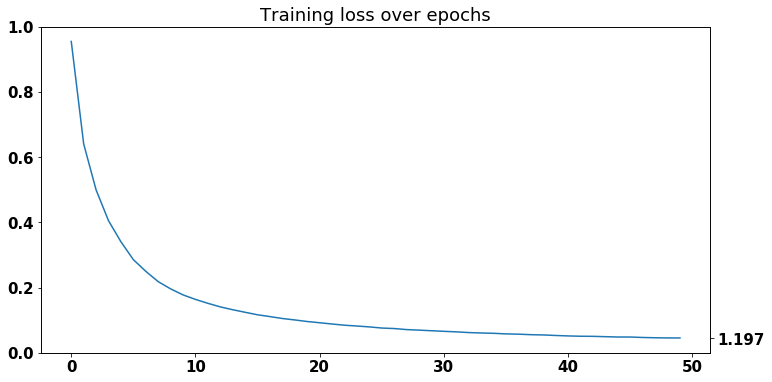

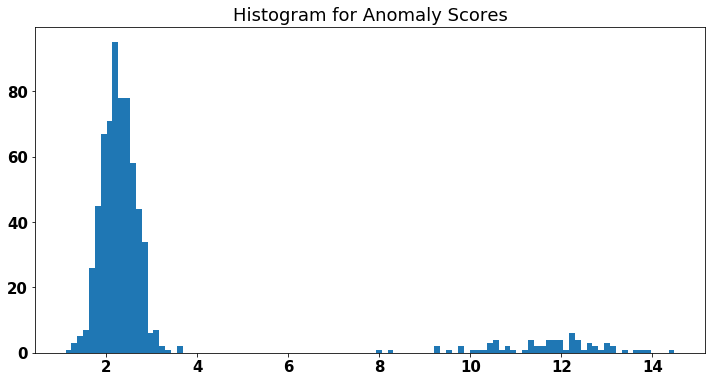

Outliers count: 70


In [108]:
# Top 1 history
plot_training_loss(trained_models[0]["model"])
plot_decision_function(
    calculate_score=True, model=trained_models[0]["model"], data=X_data
)
print(
    "Outliers count:",
    count_outliers(
        threshold=4, calculate_score=True, model=trained_models[0]["model"], data=X_data
    ),
)

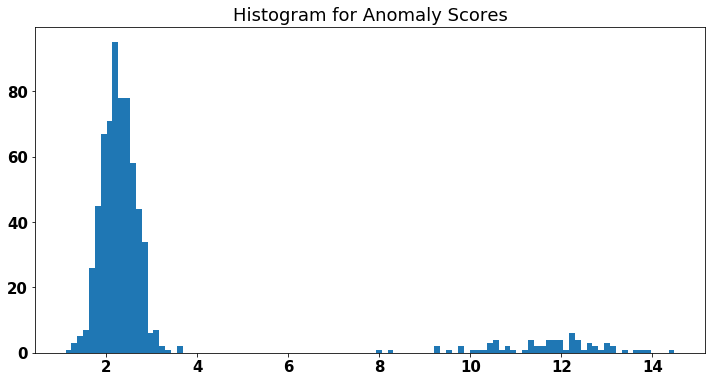

In [69]:
# Top 1 decision function
plot_decision_function(
    calculate_score=True, model=trained_models[0]["model"], data=X_data
)

In [72]:
# Top 1 outlier count
count_outliers(
    threshold=4, calculate_score=True, model=trained_models[0]["model"], data=X_data
)

70

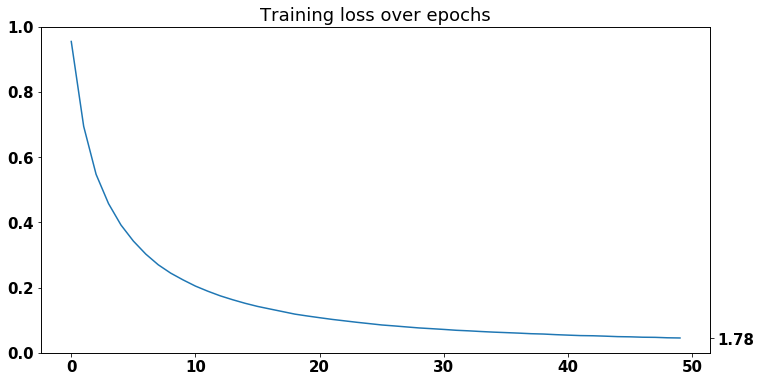

In [73]:
# Top 2 history
plot_training_loss(trained_models[1]["model"])

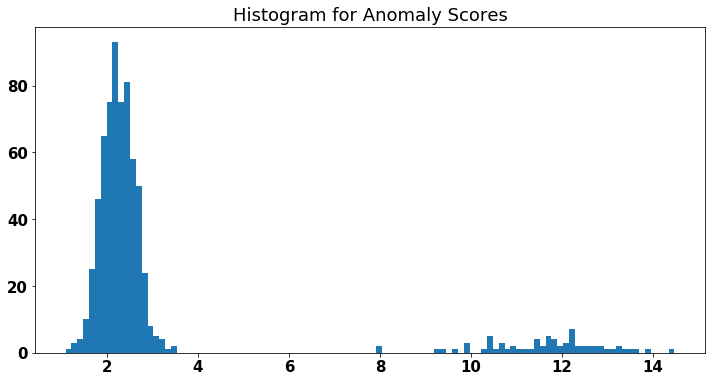

In [74]:
# Top 2 decision function
plot_decision_function(
    calculate_score=True, model=trained_models[1]["model"], data=X_data
)

In [75]:
# Top 2 outlier count
count_outliers(
    threshold=4, calculate_score=True, model=trained_models[1]["model"], data=X_data
)

70

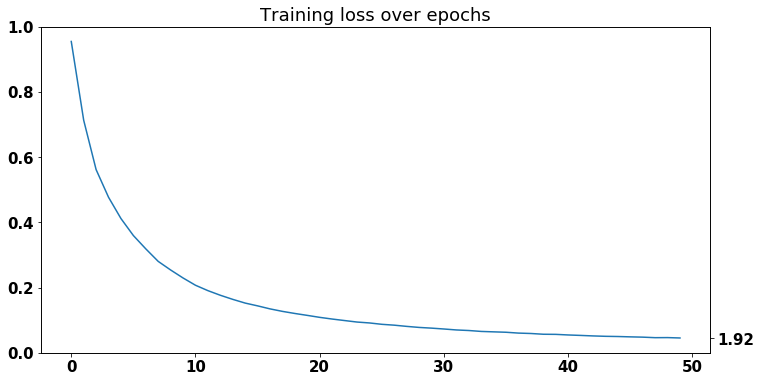

In [76]:
# Top 3 history
plot_training_loss(trained_models[2]["model"])

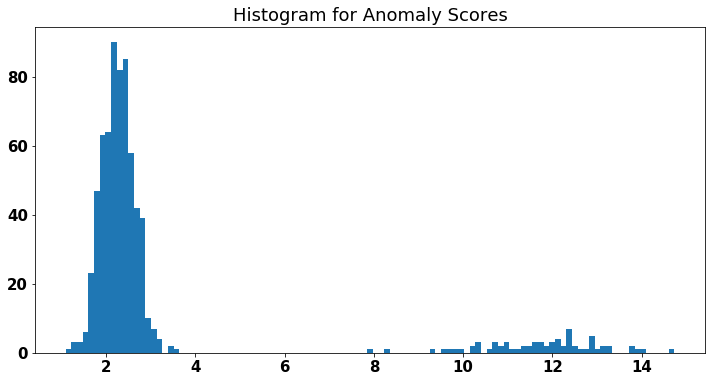

In [77]:
# Top 3 decision function
plot_decision_function(
    calculate_score=True, model=trained_models[2]["model"], data=X_data
)

In [78]:
# Top 3 outlier count
count_outliers(
    threshold=4, calculate_score=True, model=trained_models[2]["model"], data=X_data
)

70

In [ ]:
# Top 4 history


In [ ]:
# Top 4 decision function


In [ ]:
# Top 5 history


In [ ]:
# Top 5 decision function


## Essembler Class

In [99]:
class AnomallyDetectionEssembler:
    def __init__(self, *models):
        for model in models:
            if not isinstance(model, AutoEncoder):
                print(type(model))
                raise ValueError("{} is not a AutoEncoder instance".format(type(model)))

        self.models = models

        # fitting and saving a scaler for the prediction scores of the models
        # the scaler will be used to normalize the final decision of the assembler
        decision_scores = pd.DataFrame(
            [
                {"score": score}
                for score in model.decision_scores_
                for model in self.models
            ]
        )
        self.decision_scores_scaler = StandardScaler().fit(decision_scores)

    def predict(self, x, aggregation="avg"):
        """
        aggregation can be avg, max or min
        """
        if aggregation not in ["avg", "max", "min"]:
            raise ValueError("Aggregation must be avg, max or min")

        scores = self.decision_scores_scaler.transform(
            np.array([model.decision_function(x) for model in self.models]).reshape(-1, 1)
        )
        if aggregation == "avg":
            return scores.mean()
        elif aggregation == "max":
            return scores.max()
        else:
            return scores.min()

In [100]:
anomally_detection_essemble_model = AnomallyDetectionEssembler(*[model["model"] for model in trained_models])

In [101]:
essemble_model_scores = calculate_essembler_scores(anomally_detection_essemble_model, X_data)

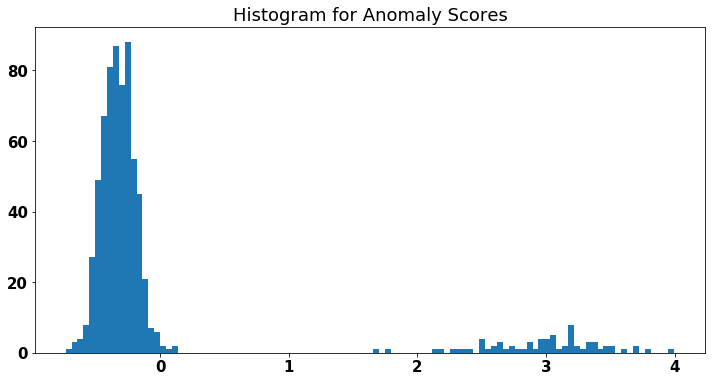

In [102]:
# Essemble model decision function
plot_decision_function(essembler_scores)

In [103]:
# Essembler outlier count
count_outliers(0.2, scores=essembler_scores)

70

## Save Model (Pickle)

In [105]:
with open('essemble_model.pkl', 'wb') as f:
    pickle.dump(anomally_detection_essemble_model, f, pickle.HIGHEST_PROTOCOL)

with open('essemble_model.pkl', 'rb') as f:
    essemble_model = pickle.load(f)

In [106]:
# testing
essemble_model.predict(X_data.iloc[[0]])

-0.25837546843852266